In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re

from sklearn.neighbors import NearestNeighbors
import scipy.sparse as sp
import scipy.sparse.linalg as spla

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

plt.rcParams.update({'font.size': 14})

Natoms = 7
DIM    = 2

In [2]:
def read_txt_file(fname):
    data = []
    with open(fname, "r") as f:
        for line in f:
            line = line.strip()
            line = line.strip(" \\n")
            line = re.sub(r"(-[0-9]+\.)", r" \1", line)
            values = [float(value) for value in line.split()]
            data.append(values)
    data = np.array(data)
    print(f"{fname}: raw shape = {data.shape}")
    return data

In [3]:
def Dist_Sq_Matrix(x):
    Na = x.shape[1]
    D2 = np.zeros((Na, Na))
    for j in range(Na):
        D2[j, :] = (x[0, :] - x[0, j])**2 + (x[1, :] - x[1, j])**2
    return D2

In [ ]:
def sort_coord_num(x):
    x_mat = np.reshape(x, (DIM, Natoms))
    D2 = Dist_Sq_Matrix(x_mat)
    coord_num = np.zeros((Natoms,))
    for j in range(Natoms):
        ind = np.setdiff1d(range(Natoms), np.array([j]))
        aux = (D2[j, ind] / 2.25)**4 
        coord_num[j] = np.sum((1.0 - aux) / (1.0 - aux**2))
    return np.sort(coord_num)

In [5]:
def LJ_energy(xy):
    x_mat = np.reshape(xy, (DIM, Natoms))
    D2 = Dist_Sq_Matrix(x_mat)
    LJ = 0.0
    for i in range(1, Natoms):
        for j in range(i):
            LJ += D2[i, j]**(-12) - D2[i, j]**(-6)
    return 4.0 * LJ

In [7]:
def compute_features_and_energy(configs):
    N = configs.shape[0]
    feats = np.zeros((N, Natoms))
    E    = np.zeros(N)
    for i in range(N):
        xy = configs[i, :]
        feats[i, :] = sort_coord_num(xy)
        E[i]        = LJ_energy(xy)
    return feats, E

In [9]:
def diffusion_map_knn(features, k=1024, eps=1.0, alpha=1.0, n_eigs=10):
    X = features
    N, d = X.shape

    nbrs = NearestNeighbors(n_neighbors=k, algorithm="auto").fit(X)
    distances, indices = nbrs.kneighbors(X)
    D2 = distances**2

    K_data = np.exp(-D2 / (4.0 * eps))
    row_idx = np.repeat(np.arange(N), k)
    col_idx = indices.ravel()
    val = K_data.ravel()
    K = sp.csr_matrix((val, (row_idx, col_idx)), shape=(N, N))

    # symmetrize
    K = 0.5 * (K + K.T)

    # density q_i
    q = np.array(K.sum(axis=1)).ravel()
    q[q == 0.0] = np.finfo(float).eps

    # anisotropic kernel
    q_alpha = q**alpha
    inv_q_alpha = 1.0 / q_alpha
    D_left  = sp.diags(inv_q_alpha, 0)
    D_right = sp.diags(inv_q_alpha, 0)
    K_alpha = D_left @ K @ D_right

    # row-normalize
    d_alpha = np.array(K_alpha.sum(axis=1)).ravel()
    d_alpha[d_alpha == 0.0] = np.finfo(float).eps
    D_inv = sp.diags(1.0 / d_alpha, 0)
    P = D_inv @ K_alpha

    # eigen-decomposition of P^T
    w, v = spla.eigs(P.T, k=n_eigs, which="LR")
    w = w.real
    v = v.real
    idx_sort = np.argsort(-np.abs(w))
    w = w[idx_sort]
    v = v[:, idx_sort]

    # normalize eigenvectors
    for j in range(n_eigs):
        norm = np.linalg.norm(v[:, j])
        if norm > 0:
            v[:, j] /= norm

    return w, v

In [6]:
bins_all = read_txt_file("LJ7bins_confs.txt")
N_raw, d = bins_all.shape
print("Total configurations (raw):", N_raw)

# remove zero configurations
mask_keep = np.sum(bins_all**2, axis=1) > 1e-10
data_aux = bins_all[mask_keep, :]
N_aux, d = data_aux.shape
print("After removing zeros:", data_aux.shape)

# split into training (used for DMap + net) and "unused" (for OOS testing)
N_train = min(5000, N_aux)
perm = np.random.permutation(N_aux)
data_train = data_aux[perm[:N_train], :]
data_unused = data_aux[perm[N_train:], :]
print("Training set:", data_train.shape)
print("Unused set:", data_unused.shape)

LJ7bins_confs.txt: raw shape = (16641, 14)
Total configurations (raw): 16641
After removing zeros: (10071, 14)
Training set: (5000, 14)
Unused set: (5071, 14)


features_train: (5000, 7)
features_unused: (5071, 7)


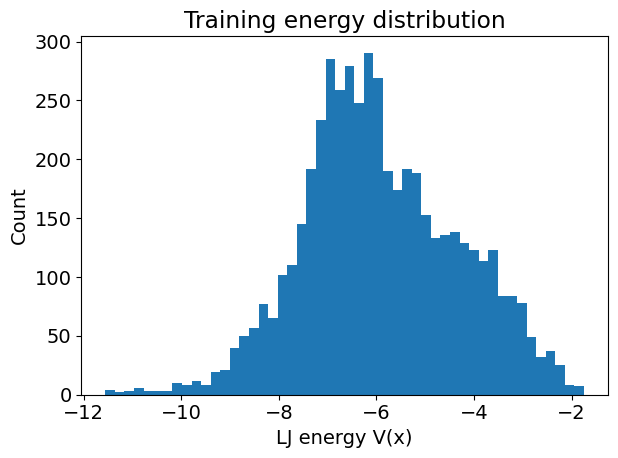

In [8]:
features_train, energies_train = compute_features_and_energy(data_train)
features_unused, energies_unused = compute_features_and_energy(data_unused)

print("features_train:", features_train.shape)
print("features_unused:", features_unused.shape)

# quick histogram for sanity
plt.figure()
plt.hist(energies_train, bins=50)
plt.xlabel("LJ energy V(x)")
plt.ylabel("Count")
plt.title("Training energy distribution")
plt.tight_layout()
plt.show()

In [27]:
k_dmap = 1024
eps_dmap = 1.0
alpha_dmap = 1.0

lambdas, psi_train = diffusion_map_knn(
    features_train, k=k_dmap, eps=eps_dmap, alpha=alpha_dmap, n_eigs=6
)
print("Top DMap eigenvalues:", lambdas[:6])

Top DMap eigenvalues: [1.         0.94966727 0.89481463 0.71004039 0.64729719 0.53807842]


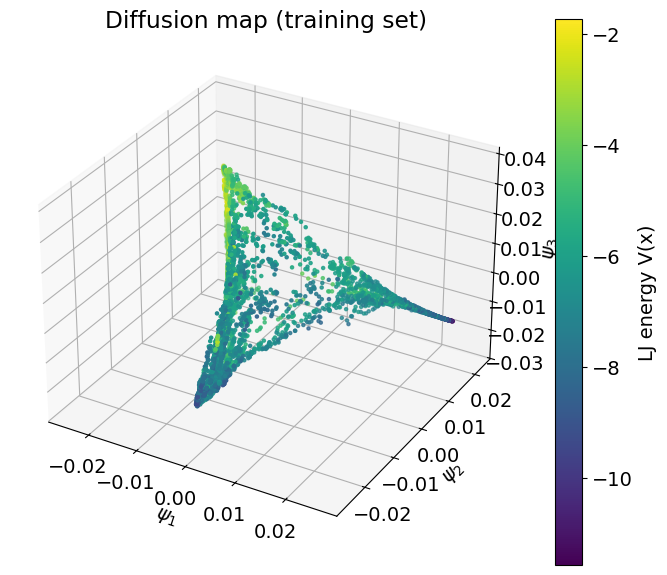

In [28]:
Y_train = psi_train[:, 1:4]   # shape (N_train, 3)

# visualize DMap on training data
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(Y_train[:, 0], Y_train[:, 1], Y_train[:, 2],
               c=energies_train, s=5, cmap="viridis")
ax.set_xlabel(r"$\psi_1$")
ax.set_ylabel(r"$\psi_2$")
ax.set_zlabel(r"$\psi_3$")
cbar = fig.colorbar(p, ax=ax)
cbar.set_label("LJ energy V(x)")
ax.set_title("Diffusion map (training set)")
plt.tight_layout()
plt.show()

In [29]:
X_mean = features_train.mean(axis=0)
X_std  = features_train.std(axis=0)
X_std[X_std == 0.0] = 1.0

Y_mean = Y_train.mean(axis=0)
Y_std  = Y_train.std(axis=0)
Y_std[Y_std == 0.0] = 1.0

X_train_std = (features_train - X_mean) / X_std
Y_train_std = (Y_train - Y_mean) / Y_std

X_train_std = X_train_std.astype(np.float32)
Y_train_std = Y_train_std.astype(np.float32)

# small train/validation split
N = X_train_std.shape[0]
perm2 = np.random.permutation(N)
N_val = int(0.2 * N)
idx_val = perm2[:N_val]
idx_tr  = perm2[N_val:]

X_tr = X_train_std[idx_tr]
Y_tr = Y_train_std[idx_tr]
X_val = X_train_std[idx_val]
Y_val = Y_train_std[idx_val]

train_ds = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(Y_tr))
val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(Y_val))

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [30]:
class EncoderNet(nn.Module):
    def __init__(self, in_dim=7, hidden_dim=64, out_dim=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )
    def forward(self, x):
        return self.net(x)

In [31]:
model = EncoderNet(in_dim=7, hidden_dim=64, out_dim=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [32]:
n_epochs = 100

for epoch in range(1, n_epochs + 1):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d} | Train MSE: {train_loss:.4e} | Val MSE: {val_loss:.4e}")


Epoch   1 | Train MSE: 6.0637e-01 | Val MSE: 2.8866e-01
Epoch  10 | Train MSE: 7.0737e-03 | Val MSE: 6.7634e-03
Epoch  20 | Train MSE: 3.0973e-03 | Val MSE: 3.1878e-03
Epoch  30 | Train MSE: 1.9397e-03 | Val MSE: 2.0755e-03
Epoch  40 | Train MSE: 1.3548e-03 | Val MSE: 1.6234e-03
Epoch  50 | Train MSE: 1.0776e-03 | Val MSE: 1.4567e-03
Epoch  60 | Train MSE: 9.0368e-04 | Val MSE: 1.2610e-03
Epoch  70 | Train MSE: 7.7054e-04 | Val MSE: 1.1656e-03
Epoch  80 | Train MSE: 6.9990e-04 | Val MSE: 1.0784e-03
Epoch  90 | Train MSE: 6.4532e-04 | Val MSE: 1.0075e-03
Epoch 100 | Train MSE: 6.3223e-04 | Val MSE: 9.3913e-04


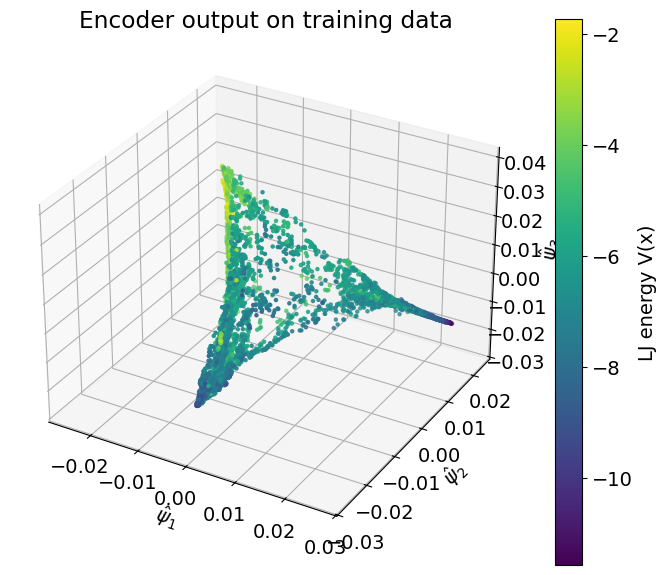

In [33]:
model.eval()
with torch.no_grad():
    X_all_torch = torch.from_numpy(X_train_std).to(device)
    Y_pred_std = model(X_all_torch).cpu().numpy()

Y_pred = Y_pred_std * Y_std + Y_mean   # back to original scale

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(Y_pred[:, 0], Y_pred[:, 1], Y_pred[:, 2],
               c=energies_train, s=5, cmap="viridis")
ax.set_xlabel(r"$\hat{\psi}_1$")
ax.set_ylabel(r"$\hat{\psi}_2$")
ax.set_zlabel(r"$\hat{\psi}_3$")
cbar = fig.colorbar(p, ax=ax)
cbar.set_label("LJ energy V(x)")
ax.set_title("Encoder output on training data")
plt.tight_layout()
plt.show()

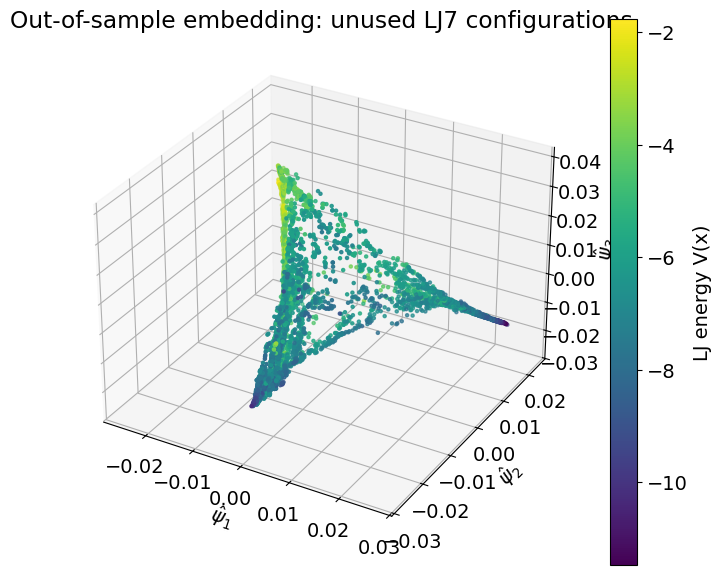

In [34]:
X_unused_std = (features_unused - X_mean) / X_std
X_unused_torch = torch.from_numpy(X_unused_std.astype(np.float32)).to(device)

model.eval()
with torch.no_grad():
    Y_unused_std = model(X_unused_torch).cpu().numpy()

Y_unused = Y_unused_std * Y_std + Y_mean

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(Y_unused[:, 0], Y_unused[:, 1], Y_unused[:, 2],
               c=energies_unused, s=5, cmap="viridis")
ax.set_xlabel(r"$\hat{\psi}_1$")
ax.set_ylabel(r"$\hat{\psi}_2$")
ax.set_zlabel(r"$\hat{\psi}_3$")
cbar = fig.colorbar(p, ax=ax)
cbar.set_label("LJ energy V(x)")
ax.set_title("Out-of-sample embedding: unused LJ7 configurations")
plt.tight_layout()
plt.show()

In [35]:
mala_data = read_txt_file("MALAtrajectory.txt")

# remove possible zero rows
mask_mala = np.sum(mala_data**2, axis=1) > 1e-10
mala_data = mala_data[mask_mala, :]
print("MALA trajectory shape after cleaning:", mala_data.shape)

MALAtrajectory.txt: raw shape = (100001, 14)
MALA trajectory shape after cleaning: (100001, 14)


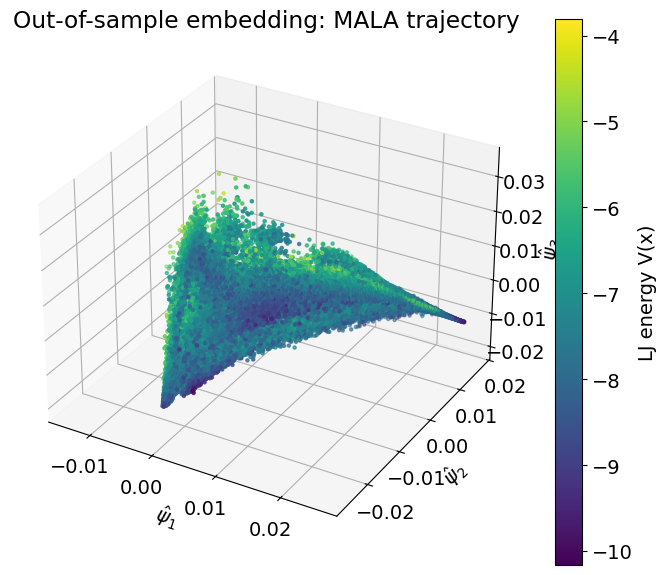

In [36]:
features_mala, energies_mala = compute_features_and_energy(mala_data)
X_mala_std = (features_mala - X_mean) / X_std

X_mala_torch = torch.from_numpy(X_mala_std.astype(np.float32)).to(device)
model.eval()
with torch.no_grad():
    Y_mala_std = model(X_mala_torch).cpu().numpy()

Y_mala = Y_mala_std * Y_std + Y_mean

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(Y_mala[:, 0], Y_mala[:, 1], Y_mala[:, 2],
               c=energies_mala, s=5, cmap="viridis")
ax.set_xlabel(r"$\hat{\psi}_1$")
ax.set_ylabel(r"$\hat{\psi}_2$")
ax.set_zlabel(r"$\hat{\psi}_3$")
cbar = fig.colorbar(p, ax=ax)
cbar.set_label("LJ energy V(x)")
ax.set_title("Out-of-sample embedding: MALA trajectory")
plt.tight_layout()
plt.show()